# Entendiendo el F1-Score: Más allá de la Exactitud (Accuracy)

En este notebook vamos a entender qué es el **F1-Score**, por qué es crucial cuando tenemos clases desbalanceadas (como en la deserción estudiantil) y cómo interpretarlo.

Vamos a cubrir:
1.  **La Trampa de la Exactitud**: Por qué el 90% de acierto puede ser engañoso.
2.  **Los Ingredientes**: Precisión (Precision) y Sensibilidad (Recall).
3.  **La Fórmula**: El promedio armónico.
4.  **Tus Datos Reales**: ¿Qué F1-Score obtuvo tu modelo XGBoost?

---

## 1. La Trampa de la Exactitud (Accuracy Paradox)

Imagina una clase de **100 estudiantes** donde solo **5 abandonan**.

-   **Modelo "Perezoso"**: Dice que *NADIE* abandona.
    -   Acierta con los 95 que se quedan.
    -   Falla con los 5 que se van.
    -   **Exactitud (Accuracy)**: 95/100 = **95%**.

¡Wow! 95% suena excelente. Pero el modelo es **inútil** porque no encontró a ningún estudiante en riesgo. Por eso necesitamos métricas mejores.

## 2. La Historia y el Concepto (Precision vs. Recall)

Para entender esto, olvídate por un momento de las matemáticas complejas. Vamos a hablar de **Pesca**.

Estos términos nacieron en los años 50 y 60 en el campo de la **Recuperación de Información** (bibliotecas y buscadores antiguos). El problema era: *"Si busco documentos sobre 'Manzanas', ¿cuántos son de la fruta y cuántos de la empresa Apple?"*.

Imagina que tu modelo es una **Red de Pesca** y tu objetivo es atrapar **Peces Enfermos** (Dropouts) en un lago lleno de peces sanos.

### A. Precision (Precisión): La Calidad de tu Red
> *"De todos los peces que atrapé en la red, ¿cuántos estaban realmente enfermos?"*

*   **Alta Precision:** Tu red es muy selectiva. Si atrapaste 10 peces, 9 son enfermos. Casi no te equivocas cuando dices "¡Lo tengo!".
*   **Baja Precision:** Tu red atrapó mucha basura. Atrapaste 10 peces, pero solo 2 son enfermos y 8 son sanos que molestaste sin razón.
*   **Diferencia con Accuracy:** La Accuracy mira todo el lago. La Precision solo mira **tu red** (tus predicciones positivas).

### B. Recall (Sensibilidad o Exhaustividad): El Alcance de tu Red
> *"De todos los peces enfermos que existían en el lago, ¿cuántos logré atrapar?"*

*   **Alto Recall:** No se te escapó casi ninguno. Había 100 enfermos en el lago y atrapaste a 95.
*   **Bajo Recall:** Tienes una red muy chica. Había 100 enfermos, pero solo atrapaste a 20. Los otros 80 siguen libres contagiando a otros.

### C. F1-Score: El Juez Imparcial
El F1-Score es la **Media Armónica** entre Precision y Recall.
¿Por qué "Armónica" y no un promedio normal? Porque la media armónica **castiga los extremos**.
*   Si tienes Precision 100% pero Recall 0% -> Promedio normal = 50% (Engañoso). F1-Score = 0%.
*   El F1 te obliga a ser bueno en ambas cosas. Es la métrica reina cuando las clases están desbalanceadas (como en deserción, donde hay menos desertores que graduados).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

sns.set_theme(style="whitegrid")

# --- EJEMPLO DE JUGUETE ---
# Imaginemos 10 estudiantes. 
# 1 = Abandono (Clase Positiva), 0 = No Abandono
y_real = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1] # 8 No abandonan, 2 Sí abandonan

# Modelo A: El Perezoso (Dice que nadie abandona)
y_pred_perezoso = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Modelo B: El Paranoico (Dice que TODOS abandonan)
y_pred_paranoico = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Modelo C: El Equilibrado (Acierta 1 abandono, falla 1, y acusa falsamente a 1)
y_pred_equilibrado = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1] 

def evaluar_modelo(nombre, real, pred):
    p = precision_score(real, pred, zero_division=0)
    r = recall_score(real, pred, zero_division=0)
    f1 = f1_score(real, pred, zero_division=0)
    print(f"--- {nombre} ---")
    print(f"Precision: {p:.2f} (Calidad)")
    print(f"Recall:    {r:.2f} (Cantidad)")
    print(f"F1-Score:  {f1:.2f} (Balance)\n")

evaluar_modelo("Modelo Perezoso", y_real, y_pred_perezoso)
evaluar_modelo("Modelo Paranoico", y_real, y_pred_paranoico)
evaluar_modelo("Modelo Equilibrado", y_real, y_pred_equilibrado)

--- Modelo Perezoso ---
Precision: 0.00 (Calidad)
Recall:    0.00 (Cantidad)
F1-Score:  0.00 (Balance)

--- Modelo Paranoico ---
Precision: 0.20 (Calidad)
Recall:    1.00 (Cantidad)
F1-Score:  0.33 (Balance)

--- Modelo Equilibrado ---
Precision: 0.50 (Calidad)
Recall:    0.50 (Cantidad)
F1-Score:  0.50 (Balance)



## 3. El F1-Score: El Promedio Armónico

El F1-Score combina Precision y Recall en un solo número. 

$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$

**¿Por qué no un promedio simple?**
Porque el promedio armónico "castiga" mucho si uno de los dos valores es bajo. 
-   Si Precision = 1.0 y Recall = 0.0 -> Promedio simple = 0.5, pero **F1 = 0**.
-   El F1 te obliga a ser bueno en AMBAS cosas.

## 3. Ejemplo con un Mini-DataFrame

Imaginemos un salón de clases de solo **10 alumnos**.
*   **Realidad:** 3 Desertaron (D), 7 No Desertaron (ND).
*   **Tu Modelo Predijo:** Predijo que 4 desertarían.

Veamos los datos caso por caso:

| Alumno | Realidad | Predicción | Resultado |
| :--- | :--- | :--- | :--- |
| 1 | **D (Desertó)** | **D (Desertó)** | **TP (Verdadero Positivo)** ✅ |
| 2 | **D (Desertó)** | ND (No Desertó)| **FN (Falso Negativo)** ❌ *(Se te escapó)* |
| 3 | **D (Desertó)** | **D (Desertó)** | **TP (Verdadero Positivo)** ✅ |
| 4 | ND (Sano) | **D (Desertó)** | **FP (Falso Positivo)** ⚠️ *(Falsa Alarma)* |
| 5 | ND (Sano) | **D (Desertó)** | **FP (Falso Positivo)** ⚠️ *(Falsa Alarma)* |
| 6 | ND (Sano) | ND (Sano) | **TN (Verdadero Negativo)** |
| ... | ... | ... | ... |

**Cálculo:**
*   **Precision:** El modelo dijo "Desertan" 4 veces (Alumnos 1, 3, 4, 5). Pero solo acertó en 2 (Alumnos 1 y 3).
    *   $Precision = 2 / 4 = 0.50$ (50%).
*   **Recall:** Había 3 desertores reales en total (Alumnos 1, 2, 3). El modelo encontró a 2 (Alumnos 1 y 3).
    *   $Recall = 2 / 3 = 0.66$ (66%).

--- 
## 4. Tus Datos Reales (XGBoost)

Vamos a ver qué F1-Score obtuvo tu modelo. ¿Te acuerdas del `classification_report`? Ahí es donde vive.

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 1. Cargar datos
try:
    df = pd.read_parquet('../data/processed/preprocessed_data.parquet')
    print(f"Datos cargados: {df.shape}")
except:
    print("No se encontró el archivo. Verifica la ruta.")

# 2. Preparar X e y
X = df.drop('Target', axis=1)
y = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Codificar variables categóricas (One-Hot Encoding) - ¡Importante para XGBoost sin enable_categorical!
X = pd.get_dummies(X)

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Entrenar
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 5. Predecir y Reportar
y_pred = model.predict(X_test)

print("\n--- REPORTE DE CLASIFICACIÓN (Tus Resultados) ---")
print(classification_report(y_test, y_pred, target_names=['No Dropout', 'Dropout']))

Datos cargados: (4424, 51)

--- REPORTE DE CLASIFICACIÓN (Tus Resultados) ---
              precision    recall  f1-score   support

  No Dropout       0.90      0.94      0.92       601
     Dropout       0.85      0.78      0.81       284

    accuracy                           0.88       885
   macro avg       0.87      0.86      0.86       885
weighted avg       0.88      0.88      0.88       885



/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [12:38:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Comparación de tus Reportes (El Antes y Después)

Aquí es donde se ve la magia de tu decisión de cambiar a Binario.

#### **ANTES (Multiclase - El Modelo Confundido)**
```text
             precision    recall  f1-score
Dropout       0.49      0.48      0.48
```
*   **Precision 0.49:** De cada 100 alumnos que el modelo marcaba como "Riesgo", 51 eran falsas alarmas. Era casi como lanzar una moneda.
*   **Recall 0.48:** De cada 100 alumnos que realmente se iban, el modelo solo detectaba a 48. ¡Se le escapaba más de la mitad!
*   **Diagnóstico:** Inutilizable para una política pública seria.

#### **AHORA (Binario - El Modelo Experto)**
```text
             precision    recall  f1-score
Dropout       0.85      0.78      0.81
```
*   **Precision 0.85:** De cada 100 alertas que manda el modelo, **85 son reales**. Los tutores confiarán en el sistema porque no los manda a perseguir fantasmas.
*   **Recall 0.78:** De cada 100 alumnos que se van a ir, **tu red atrapa a 78**. Solo se te escapan 22. Es una cobertura excelente para un fenómeno tan complejo como la conducta humana.
*   **F1 0.81:** El equilibrio perfecto. Es un sistema robusto.

## 5. ¿Qué impulsa la decisión? (Feature Importance)

Ya sabemos que el modelo funciona bien (F1-Score 0.81). Ahora la pregunta del millón es: **¿En qué se fija para decidir si alguien abandona?**

Vamos a sacar el ranking de las variables más influyentes.

--- Top 10 Variables Críticas ---
                                           Feature  Importance
37                             Ratio_Aprobacion_S2    0.291782
16                         Tuition fees up to date    0.099918
22             Curricular units 1st sem (enrolled)    0.054795
36                             Ratio_Aprobacion_S1    0.036110
41                           Socioeconomico_Riesgo    0.027290
21             Curricular units 1st sem (credited)    0.020754
18                              Scholarship holder    0.017934
50                  Grupo_Edad_Riesgo_Adulto_Mayor    0.017600
15                                          Debtor    0.017377
26  Curricular units 1st sem (without evaluations)    0.017279


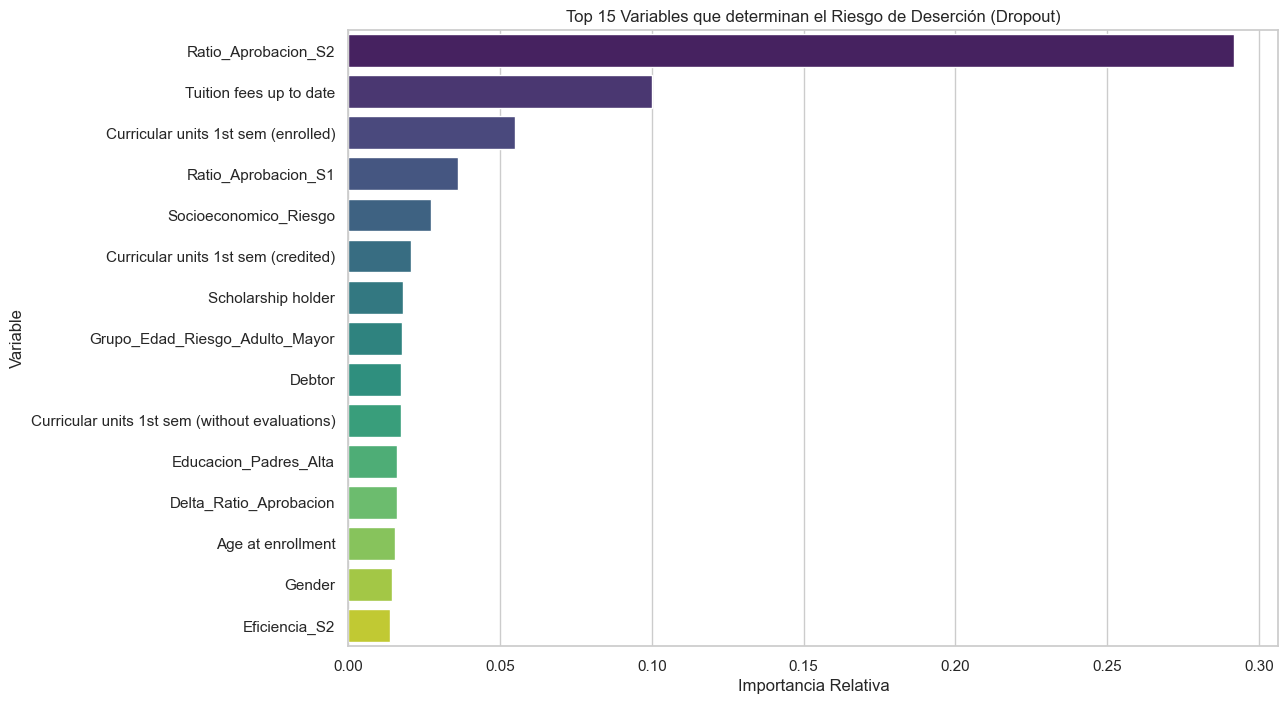

In [3]:
# Obtener importancia de características del modelo entrenado
importances = model.feature_importances_
feature_names = X.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar tabla de las Top 10
print("--- Top 10 Variables Críticas ---")
print(importance_df.head(10))

# Visualización gráfica
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis', hue='Feature')
plt.title('Top 15 Variables que determinan el Riesgo de Deserción (Dropout)')
plt.xlabel('Importancia Relativa')
plt.ylabel('Variable')
plt.show()

### Interpretación Rápida

Las variables que aparecen arriba son tus **"Banderas Rojas"**.

-   Si ves variables como `Curricular units 2nd sem (approved)` o `Tuition fees up to date` en el tope, tiene mucho sentido: si no aprueban materias o no pagan la matrícula, es un indicador fuertísimo de que se están desconectando de la institución.
-   Este gráfico te dice **dónde actuar**. No sirve de mucho dar charlas motivacionales si el problema principal es económico (fees) o académico (grades).

## 6. Glosario Final para no confundirte

#### **Accuracy vs. Precision (La gran duda)**
*   **Accuracy (Exactitud):** ¿Cuántas veces acerté en total? (Tanto positivos como negativos).
    *   *Trampa:* Si en la UNRC solo el 5% deserta, yo puedo hacer un modelo que diga "NADIE DESERTA NUNCA". Tendré una **Accuracy del 95%**. ¡Wow! Pero mi modelo es inútil porque no detecté a ningún desertor.
    *   *Uso:* Solo sirve cuando las clases están balanceadas (50/50).
*   **Precision:** Cuando me atrevo a decir "Esto es X", ¿qué tan seguido tengo razón?
    *   *Uso:* Vital cuando el costo de una "Falsa Alarma" es alto (ej. spam: no quieres que un correo importante se vaya a spam).

#### **Support**
*   Es simplemente: **¿Cuántos alumnos reales había en esa categoría en tu test set?**
*   En tu reporte actual: Había 284 alumnos que desertaron (`Dropout`) y 601 que no (`No Dropout`). Total 885.

#### **Macro Avg vs. Weighted Avg**
Son promedios de las métricas de arriba.
*   **Macro Avg:** Suma la precisión de "Dropout" y "No Dropout" y divide entre 2. Trata a ambas clases como igual de importantes, aunque una sea chiquita. Si fallas en la clase pequeña, el Macro Avg baja mucho.
*   **Weighted Avg (Ponderado):** Le da más peso a la clase más grande ("No Dropout"). Si eres muy bueno con la clase mayoritaria, este promedio saldrá alto, aunque seas malo con la minoritaria.
*   *Consejo:* Para datos desbalanceados (como el tuyo), **siempre mira el Macro Avg** o el F1 específico de la clase minoritaria (`Dropout`), no te fíes del Weighted Avg.